<a href="https://colab.research.google.com/github/jha-vineet69/Customer-Subscription-Conversion/blob/main/Conversion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>DIRECTING CUSTOMERS TO SUBSCRIPTION PRODUCTS</center>
## <center>THROUGH APP BEHAVIOUR ANALYSIS</center>
### <center>By Vineet Jha</center>
<figure>
<center>
<img src='https://drive.google.com/uc?id=1cC34IGBGDC1UmgCC5ct0Dv1hjXmSWBpC'/>
</center>
</figure>

# Introduction

In today’s market, many companies have a mobile presence. Often, these companies provide free products/services in their mobile apps in an attempt to transition their customers to a paid membership.
Some examples of paid products, which originate from free ones, are YouTube Premium, Pandora Premium, Audible Subscription, and You Need a Budget. Since marketing efforts are never free, these companies need to know exactly who to target with offers and promotions.

* Market: The target audience is customers who use a company’s free product. In this case study, this refers to users who installed (and used) the company’s free mobile app.

* Product: The paid memberships often provide enhanced versions of the free products already given for free, alongside new features. For example, Youtube Premium allows you to leave the app while still listening to a video.

* Goal: The objective of this model is to predict which users will not subscribe to the paid membership, so that greater marketing efforts can go into trying to “convert” them to paid users.

# Application

### a).  Problem Description

* In this Case Study we will be working for a fintech company that wants to provide its customers with a paid mobile app subscription that will allow them to track all of their finances in one place. To attract customers, the company releases a free version of their app with some of the main features unlocked.

* The company has tasked you to identify which users will most likely NOT enroll in the paid product, so that additional offers can be given to them. Because of the costs of these offers, the company does not want to offer them to everybody, especially customers who were going to enroll anyways.

### b).  Dataset Description

* By working for the company, we have access to each customer's app behavior data. This data allows us to see the date and time of app installation, as well as the features the users engaged with within the app. App behavior is characterized as the list of app screens the user looked at, and whether the user played the financial mini-games available.

* The app usage data is only from the user's first day in the app. This limitation exists because users can enjoy a 24-hour free trial of the premium features, and the company wants to target them with new offers shortly after the trial is over. The dataset contains record of 50K such users. 

### Importing Libraries

In [1]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jha-vineet69/Customer-Subscription-Conversion/main/appdata10.csv')

### EDA

In [3]:
dataset.head(10) # Viewing the Data

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,12-27-12 2:14 AM,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,12-2-12 1:16 AM,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,3-19-13 7:19 PM,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,7-5-13 4:08 PM,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,7-5-13 4:11 PM,0
4,51549,2-26-13 6:50 PM,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2-26-13 6:56 PM,1
5,56480,4-3-13 9:58 AM,2,09:00:00,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,4-3-13 9:59 AM,0
6,144649,12-25-12 2:33 AM,1,02:00:00,35,"product_review,product_review2,ScanPreview",3,0,0,0,NaN,0
7,249366,12-11-12 3:07 AM,1,03:00:00,26,"Splash,Cycle,Home,Credit3Container,Credit3Dash...",41,0,1,0,NaN,0
8,372004,3-20-13 2:22 PM,2,14:00:00,29,"product_review,product_review2,ScanPreview,Ver...",33,1,1,1,4-27-13 10:24 PM,0
9,338013,4-26-13 6:22 PM,4,18:00:00,26,"Home,Loan2,product_review,product_review,produ...",19,0,0,1,4-26-13 6:31 PM,0


In [4]:
dataset.describe() # Distribution of Numerical Variables

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# First set of Feature cleaning
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

In [6]:
### Plotting
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


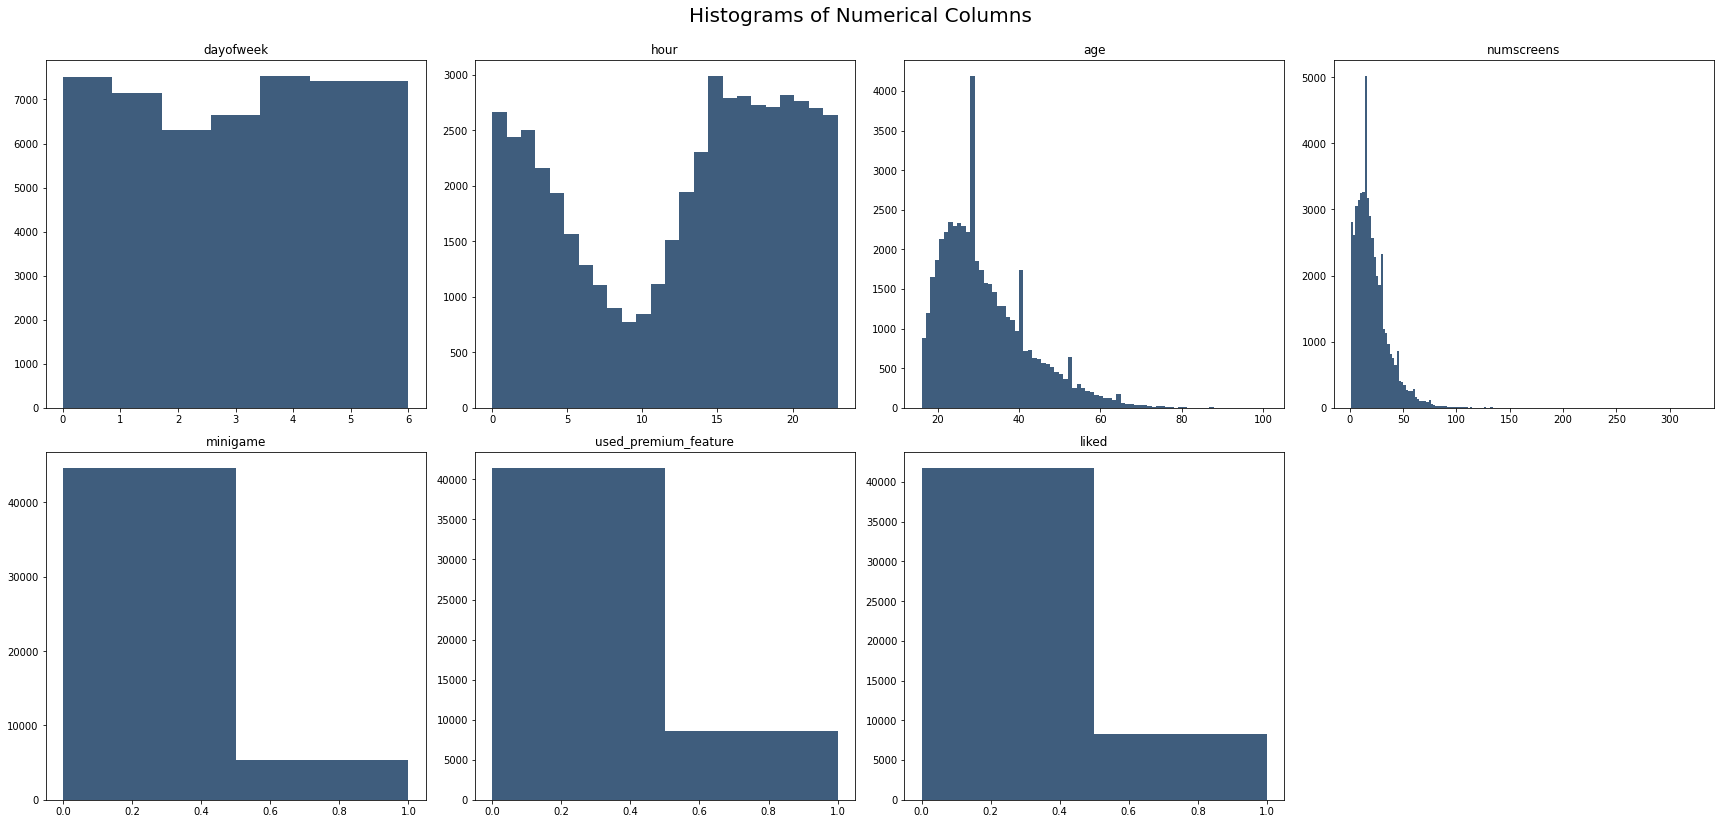

In [7]:
## Histograms
plt.figure(figsize=(24,12))
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(2, 4, i)
    f = plt.gca()
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('app_data_hist.jpg')

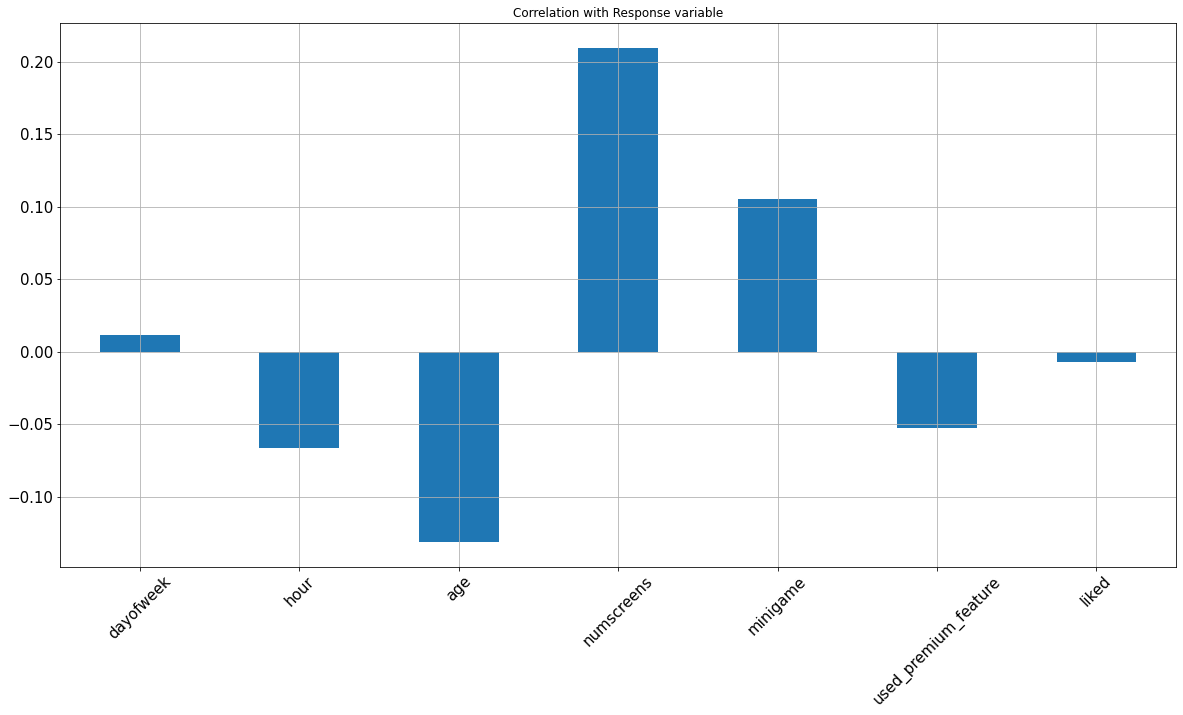

In [8]:
## Correlation with Response Variable
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Response variable',
                  fontsize = 15, rot = 45,
                  grid = True);

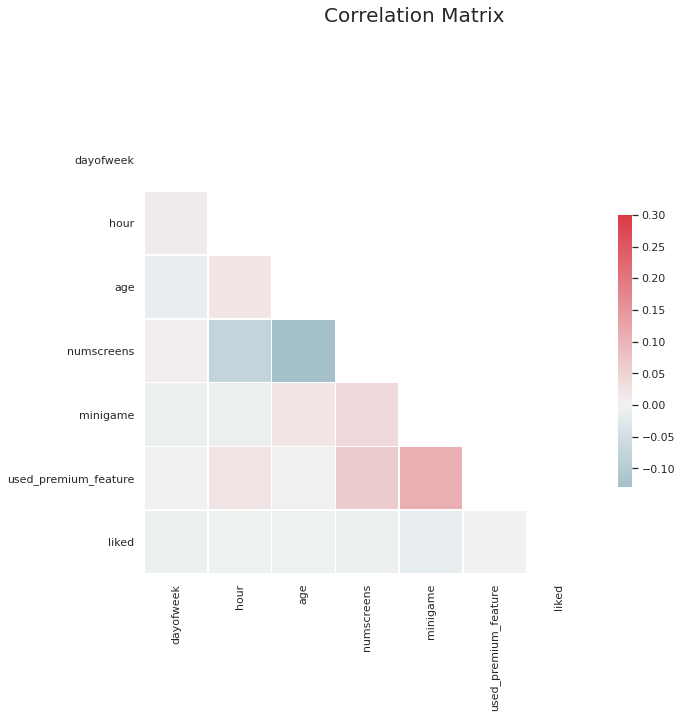

In [9]:
## Correlation Matrix
sns.set(style="white", font_scale=1)

# Compute the correlation matrix
corr = dataset2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
f.suptitle("Correlation Matrix", fontsize = 20)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Feature Engineering

In [10]:
# Formatting Date Columns
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int64
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [11]:
# dataset["first_open"] = pd.to_datetime(dataset["first_open"])
# dataset["enrolled_date"]  = pd.to_datetime(dataset["enrolled_date"])

In [12]:
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

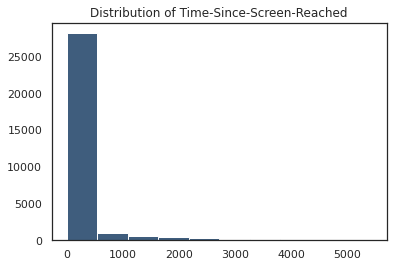

In [13]:
# Selecting Time For Response
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

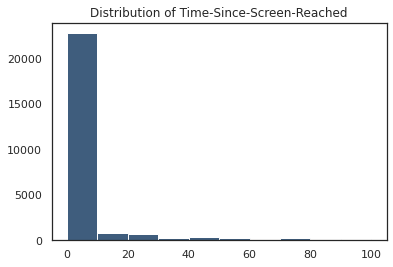

In [14]:
plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

In [15]:
dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

#### Formatting the screen_list Field

In [16]:
# Load Top Screens
top_screens = pd.read_csv('https://raw.githubusercontent.com/jha-vineet69/Customer-Subscription-Conversion/main/top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [17]:
# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

#### Funnels

In [18]:
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

In [19]:
cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

In [20]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

In [21]:
loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [22]:
dataset.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
0,235136,3,2,23,15,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,0,1


In [23]:
dataset.describe()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,186889.729900,3.029860,12.557220,31.72436,21.095900,0.107820,0.172020,0.496980,0.165000,0.517760,0.293660,0.524600,0.319540,0.473480,0.158040,0.423160,0.364860,0.340700,0.200760,0.084000,0.048980,0.076540,0.073720,0.051520,0.053860,0.045080,0.030920,0.041420,0.047560,0.0,0.0455,0.041060,0.024420,0.026220,0.023580,0.031760,0.022460,0.029800,0.021160,0.096560,0.014220,0.013340,0.013400,0.008200,0.007580,6.214260,0.365020,0.92776,0.176860,0.788400
std,107768.520361,2.031997,7.438072,10.80331,15.728812,0.310156,0.377402,0.499996,0.371184,0.499689,0.455443,0.499399,0.466303,0.499301,0.364782,0.494065,0.481396,0.473949,0.400573,0.277391,0.215828,0.265863,0.261317,0.221058,0.225743,0.207482,0.173103,0.199262,0.212836,0.0,0.2084,0.198431,0.154351,0.159791,0.151738,0.175362,0.148176,0.170037,0.143919,0.295361,0.118398,0.114727,0.114981,0.090183,0.086733,3.672561,1.405511,1.21751,0.612787,0.677462
min,13.000000,0.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,93526.750000,1.000000,5.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
50%,187193.500000,3.000000,14.000000,29.00000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.00000,0.000000,1.000000
75%,279984.250000,5.000000,19.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.00000,0.000000,1.000000
max,373662.000000,6.000000,23

In [24]:
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'SavingCount', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

In [25]:
dataset.to_csv('new_appdata10.csv', index = False)

### Data Pre-Processing

In [26]:
# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

In [27]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [28]:
# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [29]:
test_identity

11841    239786
19602    279644
45519     98290
25747    170150
42642    237568
          ...  
25091    143036
27853     91158
47278    248318
37020    142418
2217     279355
Name: user, Length: 10000, dtype: int64

In [30]:
# Feature Scaling
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [31]:
X_train.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,location,Institutions,VerifyPhone,BankVerification,VerifyDateOfBirth,ProfilePage,VerifyCountry,Cycle,idscreen,Splash,RewardsContainer,EditProfile,Finances,Alerts,Leaderboard,VerifyMobile,VerifyHousing,RewardDetail,VerifyHousingAmount,ProfileMaritalStatus,ProfileChildren,ProfileEducation,ProfileEducationMajor,Rewards,AccountView,VerifyAnnualIncome,VerifyIncomeType,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,Other,SavingCount,CMCount,CCCount,LoansCount
20330,-0.504961,1.000837,0.025525,-1.026726,-0.346830,2.186018,2.246319,-1.039218,-0.644848,-1.052581,-0.687611,-0.951190,-0.434608,-0.858628,-0.758526,-0.718780,-0.503747,-0.303366,-0.226747,-0.288018,-0.282122,-0.234146,-0.238627,-0.217955,-0.178191,-0.208406,-0.224176,0.0,-0.218583,-0.207096,-0.15631,-0.162979,-0.155384,-0.181965,-0.151889,-0.176090,-0.148055,3.035970,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-1.147303,-0.260877,-0.763372,-0.289185,1.785389
17532,-0.997389,1.135280,-0.898034,1.328829,2.883254,-0.457453,-0.445173,0.962262,1.550753,0.950046,1.454312,1.051315,-0.434608,1.164649,1.318347,1.391246,1.985123,3.296349,-0.226747,-0.288018,-0.282122,-0.234146,-0.238627,-0.217955,-0.178191,-0.208406,-0.224176,0.0,-0.218583,-0.207096,-0.15631,-0.162979,-0.155384,-0.181965,-0.151889,5.678927,-0.148055,-0.329384,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.839740,-0.260877,0.057524,-0.289185,0.309800
45819,-1.489818,-1.150250,-0.528611,4.066366,2.883254,-0.457453,-0.445173,-1.039218,1.550753,-1.052581,1.454312,-0.951190,2.300925,-0.858628,1.318347,1.391246,1.985123,3.296349,-0.226747,-0.288018,3.544562,4.270834,-0.238627,-0.217955,5.611943,-0.208406,-0.224176,0.0,-0.218583,-0.207096,-0.15631,6.135743,-0.155384,-0.181965,-0.151889,-0.176090,-0.148055,-0.329384,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.025092,-0.260877,0.878421,1.336593,1.785389
34807,0.479896,0.059736,-0.620967,0.182883,2.883254,-0.457453,-0.445173,0.962262,-0.644848,-1.052581,-0.687611,-0.951190,-0.434608,-0.858628,-0.758526,-0.718780,-0.503747,-0.303366,-0.226747,-0.288018,-0.282122,-0.234146,-0.238627,-0.217955,-0.178191,-0.208406,-0.224176,0.0,-0.218583,-0.207096,-0.15631,-0.162979,-0.155384,-0.181965,-0.151889,-0.176090,-0.148055,-0.329384,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,1.025092,-0.260877,-0.763372,-0.289185,0.309800
31888,-0.012532,0.463065,1.687932,-0.644744,-0.346830,-0.457453,-0.445173,0.962262,-0.644848,0.950046,-0.687611,1.051315,-0.434608,-0.858628,1.318347,1.391246,1.985123,-0.303366,-0.226747,-0.288018,-0.282122,-0.234146,-0.238627,-0.217955,-0.178191,-0.208406,-0.224176,0.0,-0.218583,-0.207096,-0.15631,-0.162979,-0.155384,-0.181965,-0.151889,-0.176090,-0.148055,-0.329384,-0.119697,-0.11742,-0.115879,-0.091207,-0.087221,-0.875753,-0.260877,0.878421,-0.289185,-1.165789


#### Model Building

In [32]:
# Fitting Model to the Training Set
classifier = LogisticRegression(random_state = 0, penalty = 'l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.7682

In [35]:
precision_score(y_test, y_pred) # tp / (tp + fp)

0.7618952017667135

In [36]:
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7702455855490157

In [37]:
f1_score(y_test, y_pred)

0.7660476382721035

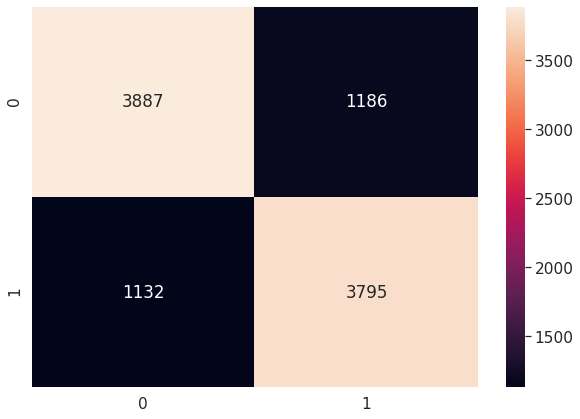

In [38]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g');

In [39]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

Accuracy: 0.767 (+/- 0.009)


In [40]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)


,features,coef
0,dayofweek,0.032571
1,hour,-0.003605
2,age,-0.149681
3,numscreens,-0.130640
4,minigame,-0.026465
5,used_premium_feature,-0.065915
6,liked,0.010690
7,location,-0.028322
8,Institutions,-0.062195
9,VerifyPhone,0.650344


#### Model Tuning

In [41]:
## Grid Search
# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

Took 34.26 seconds


In [42]:
rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

(0.76735, {'C': 0.01, 'penalty': 'l2'})

In [43]:
# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [44]:
final_results

,user,enrolled,predicted_reach
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
...,...,...,...
9995,143036,1,0
9996,91158,1,1
9997,248318,0,0
9998,142418,1,1
